## To Do
1. Make single site channel code
2. Quantum simulation
3. MI in boundary dissipation

In [27]:
import numpy as np
%matplotlib qt
import matplotlib.pyplot as pl
import time
import pickle
import os
import math

In [28]:
from transfer_matrix_reverse import free_energy_uniform, State, get_U_haar, get_U_k_1, get_U_t_1

In [29]:
def get_ancilla_array(L,T,pattern='random',preference='E',seed=1,p_O=0.5): #preference decides to give preference to E or O for initial time step in case they cannot be equally distributed
    """
    -1 corresponds to ancilla given to Environment
    +1 corresponds to ancilla given to Observer
    0 corresponds to there being no ancilla at that site
    E.g, a_structure[t,x] = -1 means that the ancilla at (x,t) belongs to Environemnt
    """
    T_scram = 2*L
    if pattern == 'checkerboard':
        a_structure = (np.indices((T+T_scram,L)).sum(axis=0) % 2)
        if preference == 'E':
            a_structure = 2*a_structure - 1
        elif preference == 'O':
            a_structure = 1-2*a_structure
        a_structure[T:,:] = 0

    if pattern == 'alternate':
        a_structure = np.ones((T+T_scram,L))
        for t in range(T):
            if preference == 'E':
                if t%2==0:
                    a_structure[t,:] = -1
            elif preference == 'O':
                if t%2==1:
                    a_structure[t,:] = -1
        a_structure[T:,:] = 0

    if pattern == 'random':
        rng = np.random.default_rng(seed=seed)
        a_structure = np.round(rng.binomial(1,p_O,(T+T_scram,L)))
        a_structure = 2*a_structure - 1
        a_structure[T:,:] = 0 

    if pattern == 'boundary':
        a_structure = np.zeros((T+T_scram,L))
        a_structure[:T,0][::2] = -1
        
        
    return a_structure

In [30]:
## Calculate coherent QI for a single encoded bell pair.
def delta_F(L,p,q,T,bell_pair_position:int,pattern='random',seed=1,preference='E',intermediate_time=False,p_O=0.5,BC='PBC'):
  
    F_t = []
    
    state_up = State(L=L,p=p,q=q)

    # get ancilla structure. This is an array which decides whether the particular ancilla goes to O or E
    a_structure = get_ancilla_array(L,T,pattern=pattern,seed=seed,preference=preference,p_O=p_O)
    depth = a_structure.shape[0]

    # Calculate free energy
    state_up,top_layer,p_cross= free_energy_uniform(state_up,depth,a_structure,bell_pair_position=bell_pair_position, intermediate_time=intermediate_time,BC=BC)
    # state_down, top_layer_down= free_energy_uniform(state_down,depth,a_structure,bell_pair_position=bell_pair_position,bell_pair_BC=0, intermediate_time=intermediate_time,BC=BC)

    # Free energy difference as a function of time
    # The log_z factors are same for up and down so can be ignored
    if intermediate_time:
        for t in range(depth):
            temp_up = top_layer[t][0] 
            temp_down = top_layer[t][1]
            F_t.append(temp_down-temp_up)
    else:
        temp_up = top_layer[-1][0]
        temp_down = top_layer[-1][1]
        F_t.append(temp_down-temp_up)
    return F_t,p_cross   

## Alternate Scheme

In [110]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0,1,20),2)
intermediate_time = True
if intermediate_time:
    F_t = {}
    p_cross_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    if intermediate_time: 
        F_t[L] = {}
        p_cross_t[L] = {}
    for p in p_list:
        diff_F,p_cross = delta_F(L,p,q,T=10*L,bell_pair_position=0,pattern='boundary',preference='O',p_O=0,intermediate_time=intermediate_time,BC='OBC')
        if intermediate_time: 
            F_t[L][p] = diff_F
            p_cross_t[L][p] = p_cross
        F[L].append(diff_F[-1])


### Studying crossing probability

##### p_R vs t 

In [191]:
%matplotlib qt
L_list2 = L_list.copy()[:]
p_list2 = p_list[:][0:10][::3]
print(p_list2)

fig,ax = pl.subplots(1,1,figsize=(10,8))
prop_cycle = pl.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['o','s','1','^']
fontsize=24



for j,p in enumerate(p_list2):
    for i,L in enumerate(L_list2):
        y_data = (1-np.array(p_cross_t[L][p])[:-2*L-1])
        x_data = (np.arange(0,len(y_data),1)[:]) - 3.1*L
        ax.plot(x_data[::2],y_data[::2],ls='-',marker=markers[j],label='L='+str(L)+'_p='+str(round(p,2)),color=colors[i])

ax.set_ylabel(r'$1-p_R(t)$',fontsize=fontsize+2)
ax.set_xlabel(r'$(t/L-4.55)L$',fontsize=fontsize)
ax.set_yscale('log')
ax.tick_params(axis='both',labelsize=fontsize)
pl.tight_layout()

pl.legend(ncol=len(p_list2),fontsize=14)

[0.   0.16 0.32 0.47]


In [199]:
list(range(9)[1::2])

[1, 3, 5, 7]

In [193]:
1/(np.log(2)/(np.log(2/5)))

-1.3219280948873622

[0.53 0.63 0.74]


Text(0.5, 1.0, '$L=18$')

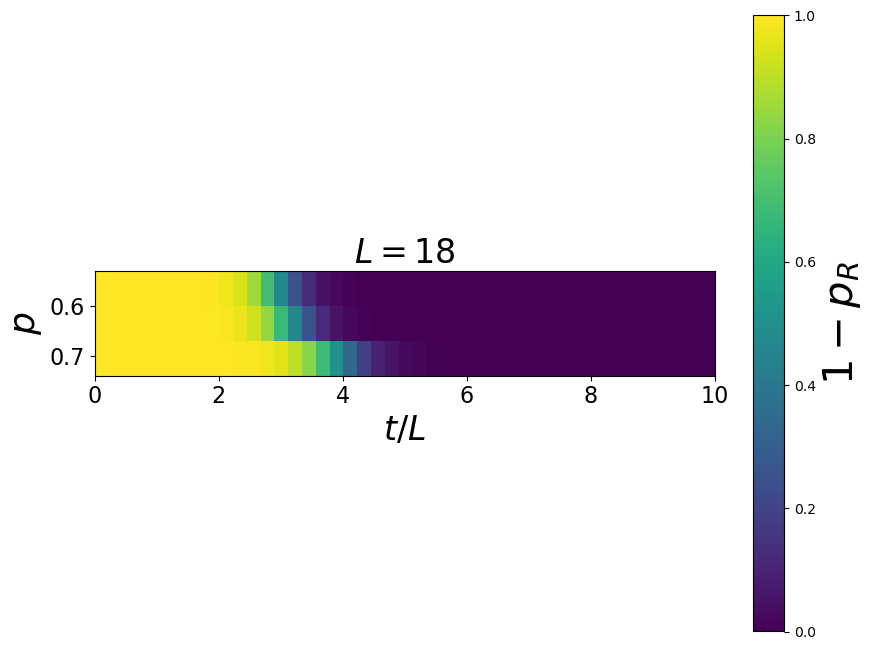

In [186]:
%matplotlib inline
L_list2 = L_list.copy()[-1:]
p_list2 = p_list[10:15][::2]
print(p_list2)

fig2,ax2 = pl.subplots(1,1,figsize=(10,8))

fontsize=24

two_d_data = []


for j,p in enumerate(p_list2):
    for i,L in enumerate(L_list2):
        y_data = (1-np.array(p_cross_t[L][p])[:-2*L])
        two_d_data.append(y_data[::4])
       
 
ax2.imshow(np.array(two_d_data),extent=[0,10,p_list2[-1],p_list2[0]],aspect=8.0) 
ax2.set_ylabel(r'$p$',fontsize=fontsize+2)
ax2.set_xlabel(r'$t/L$',fontsize=fontsize)
ax2.tick_params(axis='both',labelsize=fontsize-8)
clb = pl.colorbar(ax2.get_images()[0])
clb.set_label(r'$1-p_R$',fontsize=30)
ax2.set_title(r'$L=18$',fontsize=fontsize)
# pl.tight_layout()

# pl.legend(ncol=len(p_list2),fontsize=14)

In [174]:
np.array(two_d_data).shape

(20, 45)

In [127]:
%matplotlib qt
p = p_list[10]
fig,ax = pl.subplots(1,2,figsize=(20,10),sharey=False)
for L in F_t:
    T_data = np.arange(0,len(F_t[L][p]),1)/(L**1)
    ax[0].plot(T_data[::2],1+np.array(F_t[L][p][::2])/np.log(q),ls='-',marker='o',label='L='+str(L))
    ax[1].plot((T_data[::2]-3.21)*L**(1/1),np.array(F_t[L][p][::2])/np.log(q),ls='',marker='o',label='L='+str(L))

ax[0].set_yscale('log')

ax[0].set_ylabel(r'$1+\Delta F$',fontsize=16)
ax[0].set_xlabel(r'$T/L$',fontsize=16)
ax[1].set_xlabel(r'$(T/L-T_c)L^{1/\nu}$',fontsize=16)
ax[1].set_title(r'$T_c=3.21,\nu=1$',fontsize=16)
# ax[0].set_xlim(1.5,4.5)
ax[1].set_xlim(-30,30)
pl.legend(fontsize=14)

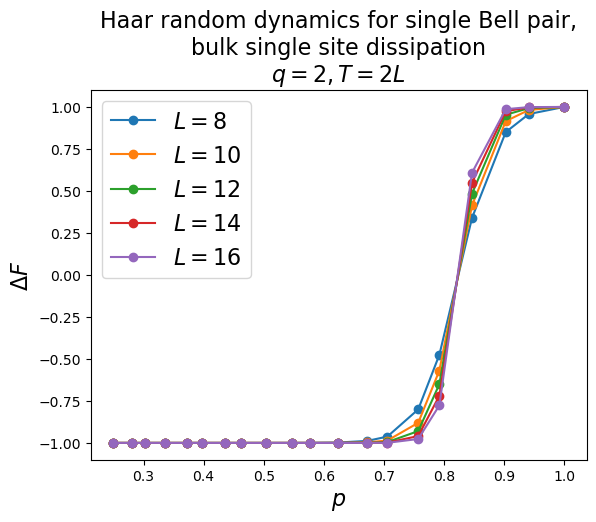

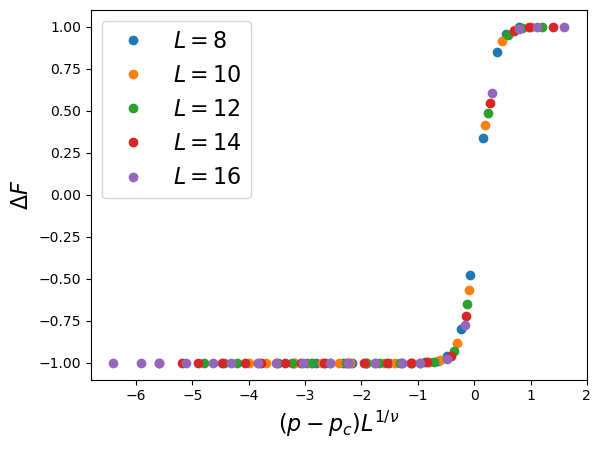

In [6]:
%matplotlib inline
p_c = 0.9
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    ax.plot(np.array(p_list)**2,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+'bulk single site dissipation'+'\n'+ '$q=2,T=2L$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


## Checkerboard

In [43]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.3,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    # F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='checkerboard',preference='E',intermediate_time=False)
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


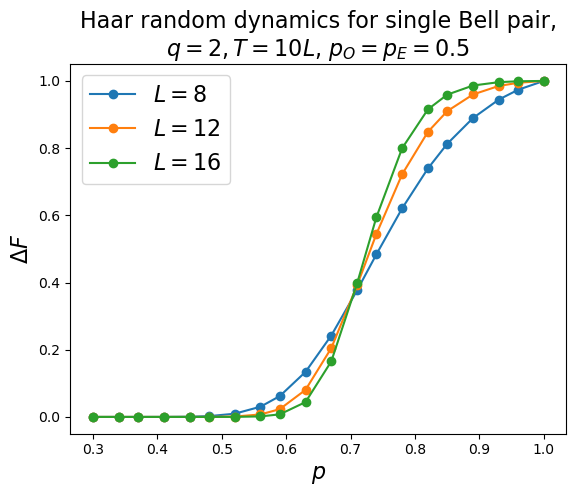

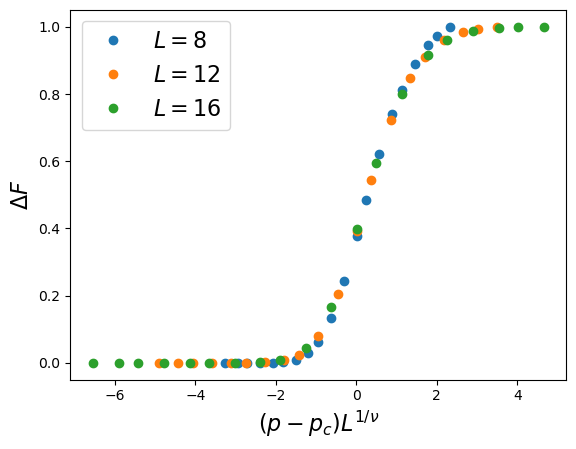

: 

In [47]:
%matplotlib inline
p_c = 0.7090
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    if L%4==2:
        continue
    ax.plot(p_list,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


# Random

In [25]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.3,1,20),2)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = {}
    # F_t[L] = {}
    for p in p_list:
        F[L][p] = []
        for seed in np.arange(1,100,1):
            diff_F = delta_F(L,p,q,pattern='random',preference='E',intermediate_time=False,p_O=0.5,seed=seed)
            if intermediate_time: F_t[L][p] = diff_F
            F[L][p].append(diff_F[-1])


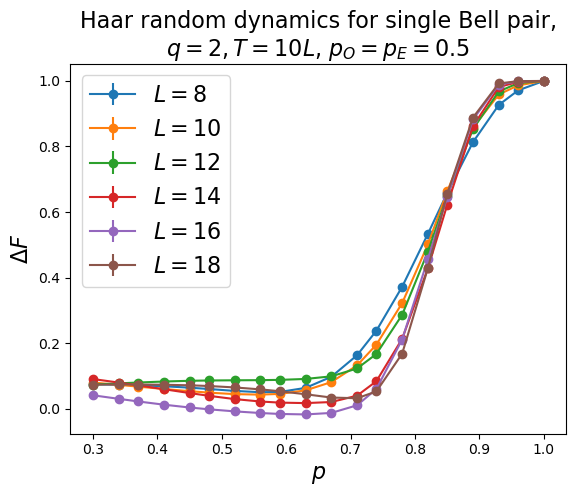

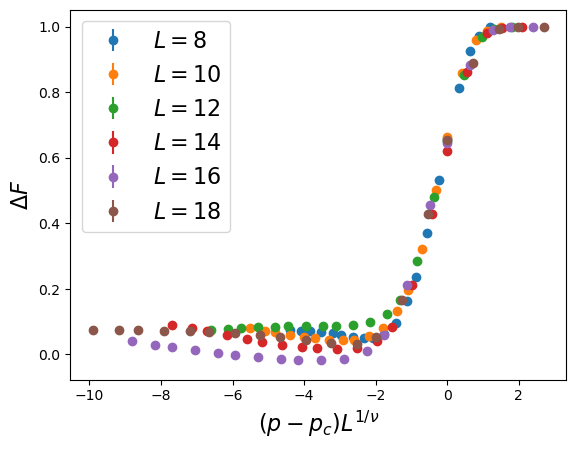

: 

In [27]:
%matplotlib inline
p_c = 0.85
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    # if L%4==2:
    #     continue
    F_avg = []
    F_err = []
    for p in F[L]:
        F_avg.append(np.average(F[L][p]))
        F_err.append(np.std(F[L][p])/len(F[L][p]))
    ax.errorbar(p_list,np.array(F_avg)/np.log(q),yerr=F_err/np.log(q),ls='-',marker='o',label = r'$L=$'+str(L))
    ax2.errorbar((np.array(p_list)-p_c)*L**(1/nu),np.array(F_avg)/np.log(q),yerr=F_err/np.log(q),ls='',marker='o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


# Boundary Disspiation

In [15]:
L_list = [8,10,12,14,16,18]
p_list = np.round(np.linspace(0.75,1,20),4)
intermediate_time = False
if intermediate_time:
    F_t = {}
F = {}
q=2
for L in L_list:
    F[L] = []
    # F_t[L] = {}
    for p in p_list:
        diff_F = delta_F(L,p,q,pattern='boundary',preference='E',intermediate_time=False)
        if intermediate_time: F_t[L][p] = diff_F
        F[L].append(diff_F[-1])


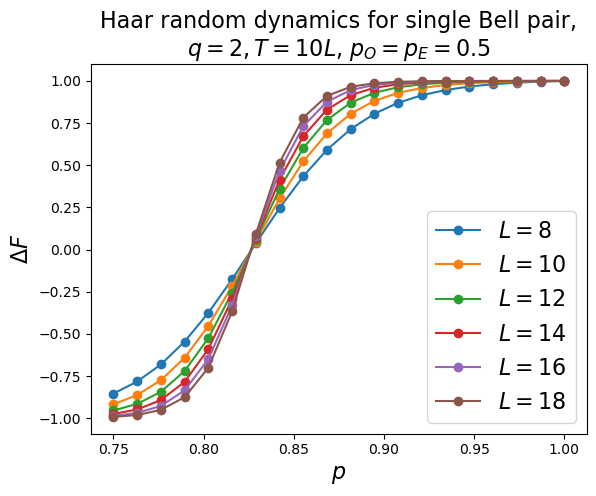

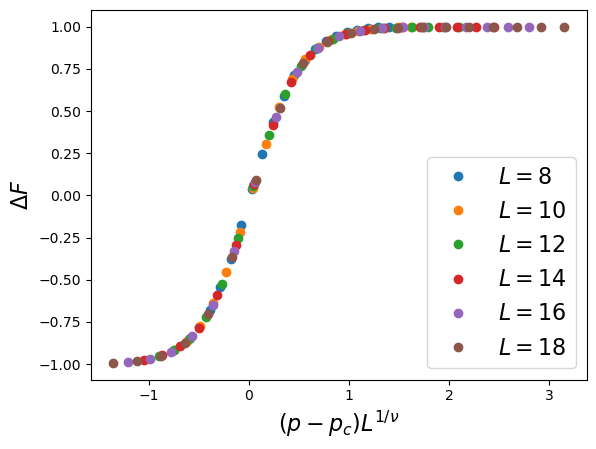

In [16]:
%matplotlib inline
p_c = 0.825
nu = 1
fig,ax = pl.subplots(1,1)
fig2,ax2 = pl.subplots(1,1)
# ax2 = pl.subplot(1,1,1,figure=2)
for L in F:
    ax.plot(p_list,np.array(F[L])/np.log(q),'-o',label = r'$L=$'+str(L))
    ax2.plot((np.array(p_list)-p_c)*L**(1/nu),np.array(F[L])/np.log(q),'o',label = r'$L=$'+str(L))

ax.set_ylabel(r'$\Delta F$',fontsize=16)
ax2.set_ylabel(r'$\Delta F$',fontsize=16)
ax.set_xlabel(r'$p$',fontsize=16)
ax2.set_xlabel(r'$(p-p_c)L^{1/\nu}$',fontsize=16)

ax.set_title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

ax.legend(fontsize=16)
ax2.legend(fontsize=16)


In [15]:
for L in [16]:
    for p in F_t[L]:
        T_data = np.arange(1,len(F_t[L][p])+1,1)[::2]/L
        pl.plot(T_data,np.array(F_t[L][p])[::2]/(np.log(q)),'-o',label = r'$p=$'+str(p))
pl.legend()

In [14]:
p_c = 0
nu = np.inf
for L in F:
    pl.plot((np.array(p_list)-p_c)*L**(1/nu),[np.array(F_t[L][p][-1])/np.log(q) for p in p_list],'-o',label = r'$L=$'+str(L))

pl.ylabel(r'$\Delta F$',fontsize=16)
pl.xlabel(r'$p$',fontsize=16)

pl.title(r'Haar random dynamics for single Bell pair,'+'\n'+ '$q=2,T=10L$, $p_O=p_E=0.5$',fontsize=16)

pl.legend(fontsize=16)
pl.tight_layout()